In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

df_trans = pd.read_csv('transactions.csv', sep=';')
df_gen = pd.read_csv('gender.csv')

In [67]:
# часть 1
df_users = pd.DataFrame()
df_users['value_sum'] = df_trans[['user_id', 'value']].groupby(['user_id']).sum() #группируем по id и суммируем для каждого 
df_users['value_mean'] = df_trans[['user_id', 'value']].groupby(['user_id']).mean()
df_users['value_std'] = df_trans[['user_id', 'value']].groupby(['user_id']).std()
df_users = df_users.merge(df_gen, on='user_id') # объединяем по id
df_users.set_index('user_id', inplace=True)

print(df_users.head())

           value_sum   value_mean   value_std  gender
user_id                                              
22899     274383.315  2143.619648  656.186785     1.0
27914     166436.523  2521.765500  415.972053     1.0
28753     251578.185  1980.930591  749.304999     0.0
31385     717856.052  2323.158744  632.491585     0.0
38084    1360028.958  2095.576206  649.030870     0.0


Рассмотрим распределение value_sum.



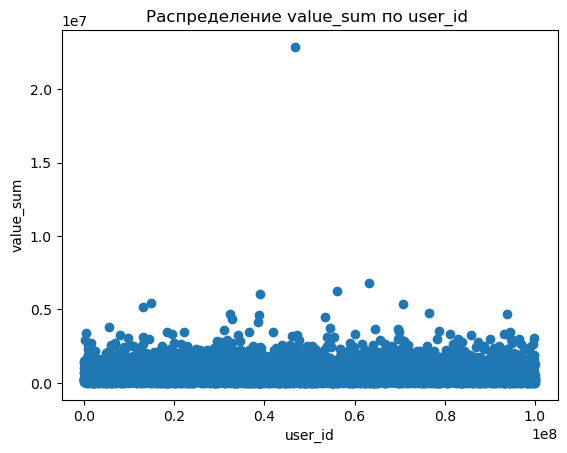


Можно заметить один явный выброс. Уберем 1% выборосов чтоб наверняка.



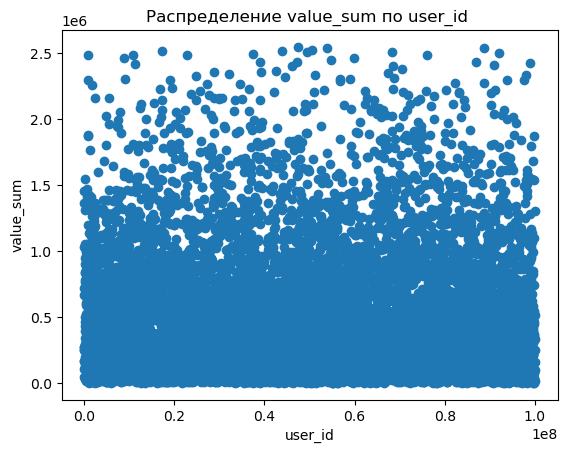

Теперь распределение выглядет гораздо лучше.


In [68]:
print('Рассмотрим распределение value_sum.')
print()

plt.scatter(df_users.index, df_users['value_sum'])
plt.ylabel('value_sum')
plt.xlabel('user_id')
plt.title('Распределение value_sum по user_id ')
plt.show()
print()

print('Можно заметить один явный выброс. Уберем 1% выборосов чтоб наверняка.')
print()

df_users = df_users[df_users['value_sum'] <= np.quantile(df_users['value_sum'], 0.99)] #убираю все такие value_sum, которые больше чем квантиль 99%

plt.scatter(df_users.index, df_users['value_sum'])
plt.ylabel('value_sum')
plt.xlabel('user_id')
plt.title('Распределение value_sum по user_id ')
plt.show()

print('Теперь распределение выглядет гораздо лучше.')

Рассмотрим как gender распределен



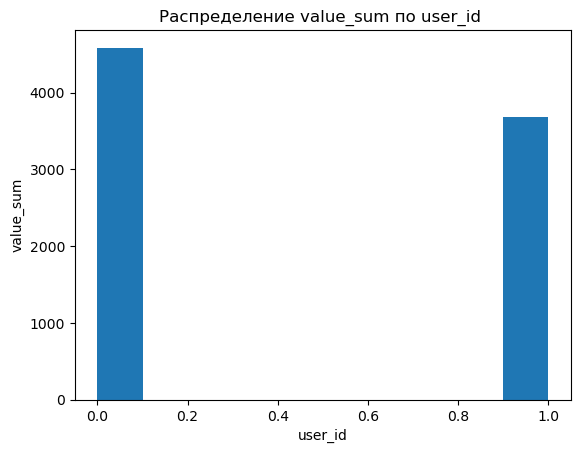


gender распределен относительно равномерно. Сделаю stratify все равно.

Рассмотрим есть ли пропуски.

value_sum      0
value_mean     0
value_std     40
dtype: int64

value_sum     0
value_mean    0
value_std     7
dtype: int64

Пропуски есть только в СКО. Заполним средними по СКО.


In [69]:
print('Рассмотрим как gender распределен')
print()

plt.hist(df_users['gender'])
plt.ylabel('value_sum')
plt.xlabel('user_id')
plt.title('Распределение value_sum по user_id ')
plt.show()
print()

print('gender распределен относительно равномерно. Сделаю stratify все равно.')
print()


df_train, df_test = train_test_split(df_users, test_size=0.2, stratify=df_users['gender'], random_state=777)
x_train, x_test = df_train.drop('gender',axis=1), df_test.drop('gender',axis=1)
y_train, y_test = df_train['gender'], df_test['gender']

print('Рассмотрим есть ли пропуски.')
print()
print(x_train.isnull().sum())
print()
print(x_test.isnull().sum())
print()
print('Пропуски есть только в СКО. Заполним средними по СКО.')

In [70]:
x_train = x_train.fillna(np.mean(x_train['value_std'])) # Пропуски есть только в СКО. Заполню средним для СКО.
x_test = x_test.fillna(np.mean(x_train['value_std'])) # Здесь взял среднее по тренировочной выборке для реалистичности))

model = LogisticRegression()
model.fit(x_train, y_train)
p_pred = model.predict_proba(x_test)[:, 1]
y_pred = model.predict(x_test)

print('Предсказания вероятностей первого класса:', p_pred)
print()

p_pred = 1*(p_pred >= 0.5)

print('ROC-AUC:', roc_auc_score(y_test, p_pred))
print()
print('Accuracy:', accuracy_score(y_test, y_pred))
print()
print('Precision:', precision_score(y_test, y_pred))
print()
print('Recall:', recall_score(y_test, y_pred))
print()

print('Модель по своим метрикам получилась посредственная. Проблемы- слишком высокий порог, неотнормированные данные, слишком мало данных (фактически, есть лишь статистики одного и того же показателя- value_sum).')

Предсказания вероятностей первого класса: [0.46063276 0.45601169 0.44048037 ... 0.46549933 0.48892418 0.49172586]

ROC-AUC: 0.5095932991016398

Accuracy: 0.5607250755287009

Precision: 0.5961538461538461

Recall: 0.04206241519674356

Модель по своим метрикам получилась посредственная. Проблемы- слишком высокий порог, неотнормированные данные, слишком мало данных (фактически, есть лишь статистики одного и того же показателя- value_sum).


In [71]:
#часть 2

table = pd.pivot_table(df_trans, columns='type', values='value', index='user_id', aggfunc=np.sum, fill_value=0) # Все наны заполняю нулями, потому что по сути где нан- там было транзакций на 0 рублей
table = table.merge(df_gen, on='user_id')

print(table.head())

   user_id  Авиалинии, авиакомпании  \
0    22899                      0.0   
1    27914                      0.0   
2    28753                      0.0   
3    31385                      0.0   
4    38084                      0.0   

   Авиалинии, авиакомпании, нигде более не классифицированные  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            
4                                                0.0            

   Автобусные линии  Автозапчасти и аксессуары  \
0               0.0                        0.0   
1               0.0                        0.0   
2               0.0                        0.0   
3               0.0                        0.0   
4               0.0                        0.0   

   Автоматизированные бензозаправки  Автомойки  Автошины  \
0            

In [72]:
df_train, df_test = train_test_split(table, test_size=0.2, stratify=table['gender'], random_state=777)
x_train, x_test = df_train.drop('gender', axis=1), df_test.drop('gender', axis=1)
y_train, y_test = df_train['gender'], df_test['gender']

model = LogisticRegression()
model.fit(x_train, y_train)

p_pred = model.predict_proba(np.array(x_test))[:, 1]
y_pred = model.predict(x_test)

print('Предсказания вероятностей первого класса:', p_pred)
print()

p_pred = 1*(p_pred >= 0.5)

print('ROC-AUC:', roc_auc_score(y_test, p_pred))
print()
print('Accuracy:', accuracy_score(y_test, p_pred))
print()
print('Precision:', precision_score(y_test, p_pred))
print()
print('Recall:', recall_score(y_test, p_pred))
print()
print('У модели немного снизилась полнота, однако значительно выросла точность. Мне кажется, что это связано с увелеченем количества и качества входных данных.')

Предсказания вероятностей первого класса: [0.40990175 0.38107566 0.49465315 ... 0.16635682 0.97785342 0.66110637]

ROC-AUC: 0.6280855708487021

Accuracy: 0.6537081339712919

Precision: 0.7012048192771084

Recall: 0.3900804289544236

У модели немного снизилась полнота, однако значительно выросла точность. Мне кажется, что это связано с увелеченем количества и качества входных данных.


In [73]:
#часть 3
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Рассмотрим график альфы.


Best alpha = 0.0320



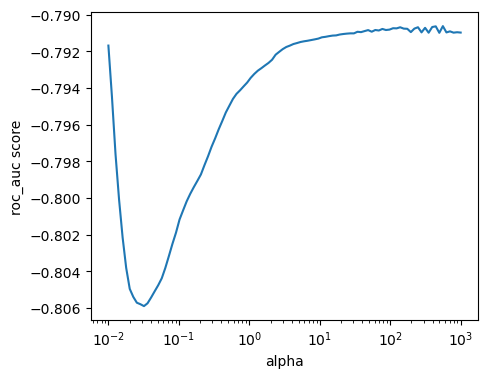

In [74]:
lg_C = np.logspace(-2, 3, 100) #Диапозон подобрал вручную. Но на нем вроде и достигается экстремум
searcher = GridSearchCV(LogisticRegression(solver='liblinear', penalty='l1'), [{'C': lg_C}], scoring="roc_auc", cv=4)
searcher.fit(x_train_scaled, y_train)

print('Рассмотрим график альфы.')
print()

plt.figure(figsize=(5,4))
plt.plot(lg_C, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("roc_auc score");
print()


best_alpha = searcher.best_params_['C']
print("Best alpha = %.4f" % best_alpha)
print()

In [75]:
model = LogisticRegression(C=best_alpha)
model.fit(x_train_scaled, y_train)

p_pred = model.predict_proba(x_test_scaled)[:, 1]
y_pred = model.predict(x_test_scaled)

print('Предсказания вероятностей первого класса:', p_pred)
print()

p_pred = 1*(p_pred >= 0.5)

print('ROC-AUC:', roc_auc_score(y_test, p_pred))
print()
print('Accuracy:', accuracy_score(y_test, p_pred))
print()
print('Precision:', precision_score(y_test, p_pred))
print()
print('Recall:', recall_score(y_test, p_pred))
print()
print('Удалось добиться лучшего качества модели. Это связано с тем, что мы подобрали оптимальное значение C. Мы использовали CV и тестовую выборку для того, чтобы избежать переобучения модели на тестовую выборку при подборе C.')

Предсказания вероятностей первого класса: [0.41022557 0.40860092 0.51047943 ... 0.18312237 0.99833259 0.88063208]

ROC-AUC: 0.6948679494380396

Accuracy: 0.7141148325358851

Precision: 0.7669322709163346

Recall: 0.5160857908847185

Удалось добиться лучшего качества модели. Это связано с тем, что мы подобрали оптимальное значение C. Мы использовали CV и тестовую выборку для того, чтобы избежать переобучения модели на тестовую выборку при подборе C.


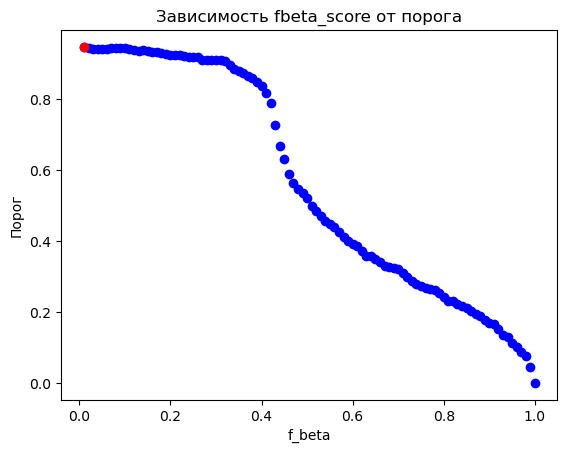

Оптимальная f_beta_score равна 0.948811519873755 при пороге в 0.01.


In [76]:
p_pred = model.predict_proba(x_test_scaled)[:, 1]

f_bet_optim = -1
porog = 0
i = 0

while i <= 1: 
    i += 0.01
    a = p_pred
    a = 1*(a >= i)
    plt.scatter(i, fbeta_score(y_test, a, beta=5),color='blue')
    if f_bet_optim < fbeta_score(y_test, a, beta=5): 
        f_bet_optim = fbeta_score(y_test, a, beta=5)
        porog = i
        
plt.scatter(porog, f_bet_optim, color='red')
plt.ylabel('Порог')
plt.xlabel('f_beta')
plt.title('Зависимость fbeta_score от порога')
plt.show()        

print(f'Оптимальная f_beta_score равна {f_bet_optim} при пороге в {porog}.')

In [77]:
model = LogisticRegression(C=best_alpha)
model.fit(x_train_scaled, y_train)

p_pred = model.predict_proba(x_test_scaled)[:, 1]
y_pred = model.predict(x_test_scaled)

print('Предсказания вероятностей первого класса:', p_pred)
print()

p_pred = 1*(p_pred >= porog)

print('ROC-AUC:', roc_auc_score(y_test, p_pred))
print()
print('Accuracy:', accuracy_score(y_test, p_pred))
print()
print('Precision:', precision_score(y_test, p_pred))
print()
print('Recall:', recall_score(y_test, p_pred))
print()
print('Модель стала лучше. Особенное внимание отдаем полноте.')

Предсказания вероятностей первого класса: [0.41022557 0.40860092 0.51047943 ... 0.18312237 0.99833259 0.88063208]

ROC-AUC: 0.5164969108101379

Accuracy: 0.465311004784689

Precision: 0.45454545454545453

Recall: 0.9919571045576407

Модель стала лучше. Особенное внимание отдаем полноте.


In [78]:
features_zero = np.where(model.coef_[0] < 0)[0] # берем веса, которые "положительно" склоняют модель к нулю
features_one = np.where(model.coef_[0] > 0)[0]
features_zero = table.columns[1:].values[features_zero]  #из pivot table убрал 'user_id'
features_one = table.columns[1:].values[features_one]

print('Признаки, которые увеличивают вероятность 0:')
print(features_zero)
print()
print('Признаки, которые увеличивают вероятность 1:')
print(features_one)

Признаки, которые увеличивают вероятность 0:
['Аксессуары для женщин' 'Аптеки'
 'Ассоциации — гражданские, социальные и братские'
 'Бакалейные магазины, супермаркеты' 'Билльярд-клубы' 'Видеопрокат'
 'Дантисты, ортодонтисты' 'Денежные переводы'
 'Денежные переводы MasterCard MoneySend' 'Жилье — отели, мотели, курорты'
 'Зоомагазины' 'Зубные и медицинские лаборатории'
 'Изготовление и продажа меховых изделий' 'Иной сервис'
 'Информационные провайдеры' 'Кинотеатры' 'Книжные магазины'
 'Колледжи, университеты, профессиональные школы и младшие колледжи'
 'Коммунальные услуги — электричество, газ, санитария, вода'
 'Компьютерная сеть/информационные услуги' 'Круизные линии'
 'Лесо- и строительный материал'
 'Магазины second hand, магазины б/у товаров, комиссионки'
 'Магазины звукозаписи'
 'Магазины кожаных изделий, дорожных принадлежностей' 'Магазины косметики'
 'Магазины мужской и женской одежды'
 'Магазины открыток, подарков, новинок и сувениров'
 'Магазины офисных, школьных принадлежностей

В данной задачи для нас важнее полнота, посколько предложить "мужскую акцию" девушке не так страшно, как не предложить "мужскую акцию" мужчине. Однако точность в районе 0.5 - грустно. Предположим что Полнота важнее точности в 2 раза.



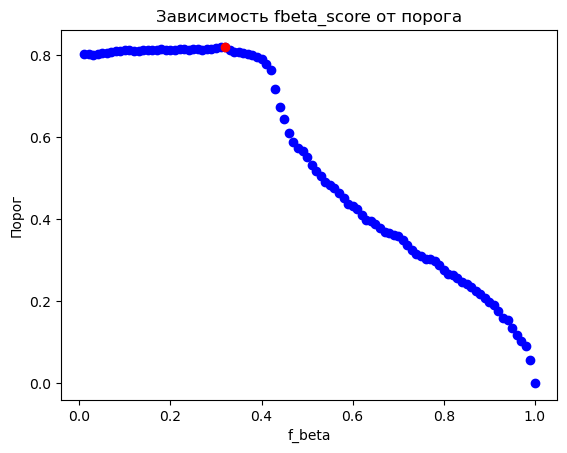

Оптимальная f_beta_score равна 0.8203677510608203 при пороге в 0.3200000000000001.

Предсказания вероятностей первого класса: [0.41022557 0.40860092 0.51047943 ... 0.18312237 0.99833259 0.88063208]

ROC-AUC: 0.6630322121147199

Accuracy: 0.6339712918660287

Precision: 0.5532591414944356

Recall: 0.9329758713136729



In [79]:
#часть 4
print('В данной задачи для нас важнее полнота, посколько предложить "мужскую акцию" девушке не так страшно, как не предложить "мужскую акцию" мужчине. Однако точность в районе 0.5 - грустно. Предположим что Полнота важнее точности в 2 раза.')
print()
p_pred = model.predict_proba(x_test_scaled)[:, 1]

f_bet_optim = -1
porog = 0
i = 0

while i <= 1: 
    i += 0.01
    a = p_pred
    a = 1*(a >= i)
    plt.scatter(i, fbeta_score(y_test, a, beta=2),color='blue')
    if f_bet_optim < fbeta_score(y_test, a, beta=2): 
        f_bet_optim = fbeta_score(y_test, a, beta=2)
        porog = i
        
plt.scatter(porog, f_bet_optim, color='red')
plt.ylabel('Порог')
plt.xlabel('f_beta')
plt.title('Зависимость fbeta_score от порога')
plt.show()        

print(f'Оптимальная f_beta_score равна {f_bet_optim} при пороге в {porog}.')
print()

model = LogisticRegression(C=best_alpha)
model.fit(x_train_scaled, y_train)

p_pred = model.predict_proba(x_test_scaled)[:, 1]
y_pred = model.predict(x_test_scaled)

print('Предсказания вероятностей первого класса:', p_pred)
print()

p_pred = 1*(p_pred >= porog)

print('ROC-AUC:', roc_auc_score(y_test, p_pred))
print()
print('Accuracy:', accuracy_score(y_test, p_pred))
print()
print('Precision:', precision_score(y_test, p_pred))
print()
print('Recall:', recall_score(y_test, p_pred))
print()